In [85]:
import pandas as pd
from pathlib import Path
import numpy as np

# Load the raw data
path = Path("data/nlsy_cleaned.csv")
df = pd.read_csv(path)

In [86]:
df.head()

,id,year,region,nervous,calm,down,happy,depressed,income,msa,...,moved,sunlight,sunlight_lag,sunlight_change,sunlight_increase,sunlight_move_interaction,nervous_rev,down_rev,depressed_rev,mh_index
0,1.0,2000,1.0,3.0,3.0,3.0,3.0,3.0,128000.0,3.0,...,0,3.5,NaN,NaN,0,NaN,2.0,2.0,2.0,2.4
1,1.0,2001,1.0,NaN,NaN,NaN,NaN,NaN,177000.0,3.0,...,0,3.5,3.5,0.0,0,0.0,NaN,NaN,NaN,NaN
2,1.0,2002,1.0,1.0,4.0,2.0,3.0,2.0,128000.0,3.0,...,0,3.5,3.5,0.0,0,0.0,4.0,3.0,3.0,3.4
3,1.0,2003,1.0,NaN,NaN,NaN,NaN,NaN,185000.0,3.0,...,0,3.5,3.5,0.0,0,0.0,NaN,NaN,NaN,NaN
4,1.0,2004,1.0,1.0,4.0,1.0,4.0,1.0,200000.0,3.0,...,0,3.5,3.5,0.0,0,0.0,4.0,4.0,4.0,4.0


In [93]:
import pandas as pd
import statsmodels.formula.api as smf

df2 = df.copy()
df2.drop(columns='sunlight_increase', inplace=True)

df2["move_year"] = (
    df2.loc[df2["moved"] == 1]
       .groupby("id")["year"]
       .transform("min")
)
df2["move_year"] = df2.groupby("id")["move_year"].transform("first")

# ----------------------------------------------------
# 3. POST = 1 after move year, else 0
#    People who never moved keep move_year = NaN → post=0
# ----------------------------------------------------
df2["post"] = (df2["year"] >= df2["move_year"]).astype(int)
df2["post"] = df2["post"].fillna(0).astype(int)

# ----------------------------------------------------
# 4. TREATMENT: person ever moved to lower sunlight region
#    Must be defined at the ID level
# ----------------------------------------------------
df2["treat"] = (
    df2.groupby("id")["sunlight_change"]
       .transform(lambda x: ((x < 0).any()))
).fillna(0).astype(int)

# ----------------------------------------------------
# 5. DID interaction
# ----------------------------------------------------
df2["did"] = df2["treat"] * df2["post"]

df2.head(10)

,id,year,region,nervous,calm,down,happy,depressed,income,msa,...,sunlight_change,sunlight_move_interaction,nervous_rev,down_rev,depressed_rev,mh_index,move_year,post,treat,did
0,1.0,2000,1.0,3.0,3.0,3.0,3.0,3.0,128000.0,3.0,...,NaN,NaN,2.0,2.0,2.0,2.4,2008.0,0,0,0
1,1.0,2001,1.0,NaN,NaN,NaN,NaN,NaN,177000.0,3.0,...,0.0,0.0,NaN,NaN,NaN,NaN,2008.0,0,0,0
2,1.0,2002,1.0,1.0,4.0,2.0,3.0,2.0,128000.0,3.0,...,0.0,0.0,4.0,3.0,3.0,3.4,2008.0,0,0,0
3,1.0,2003,1.0,NaN,NaN,NaN,NaN,NaN,185000.0,3.0,...,0.0,0.0,NaN,NaN,NaN,NaN,2008.0,0,0,0
4,1.0,2004,1.0,1.0,4.0,1.0,4.0,1.0,200000.0,3.0,...,0.0,0.0,4.0,4.0,4.0,4.0,2008.0,0,0,0
5,1.0,2005,1.0,NaN,NaN,NaN,NaN,NaN,210000.0,3.0,...,0.0,0.0,NaN,NaN,NaN,NaN,2008.0,0,0,0
6,1.0,2006,1.0,1.0,4.0,1.0,4.0,1.0,321273.0,3.0,...,0.0,0.0,4.0,4.0,4.0,4.0,2008.0,0,0,0
7,1.0,2007,1.0,NaN,NaN,NaN,NaN,NaN,125000.0,3.0,...,0.0,0.0,NaN,NaN,NaN,NaN,2008.0,0,0,0
8,1.0,2008,NaN,3.0,3.0,3.0,3.0,3.0,42500.0,3.0,...,NaN,NaN,2.0,2.0,2.0,2.4,2008.0,1,0,0
9,1.0,2009,NaN,NaN,NaN,NaN,NaN,NaN,143500.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,2008.0,1,0,0


In [96]:
df2.groupby("treat")["id"].nunique()

treat
0    8430
1     553
Name: id, dtype: int64

In [94]:
print(df2["post"].value_counts(dropna=False))
print(df2["treat"].value_counts(dropna=False))
print(df2["moved"].value_counts(dropna=False))


post
0    54633
1    44191
Name: count, dtype: int64
treat
0    92741
1     6083
Name: count, dtype: int64
moved
0    82514
1    16310
Name: count, dtype: int64


In [ ]:
needed_cols = [
    "id", "year",
    "mh_index",
    "treat", "post", "did",
    "move_year",
    "income", "msa", "urban_rural"
]

df_clean = df2[needed_cols].copy()
df_clean.head(10)


,id,year,mh_index,treat,post,did,move_year,income,msa,urban_rural
0,1.0,2000,2.4,0,0,0,2008.0,128000.0,3.0,1.0
1,1.0,2001,NaN,0,0,0,2008.0,177000.0,3.0,1.0
2,1.0,2002,3.4,0,0,0,2008.0,128000.0,3.0,1.0
3,1.0,2003,NaN,0,0,0,2008.0,185000.0,3.0,1.0
4,1.0,2004,4.0,0,0,0,2008.0,200000.0,3.0,1.0
5,1.0,2005,NaN,0,0,0,2008.0,210000.0,3.0,1.0
6,1.0,2006,4.0,0,0,0,2008.0,321273.0,3.0,1.0
7,1.0,2007,NaN,0,0,0,2008.0,125000.0,3.0,1.0
8,1.0,2008,2.4,0,1,0,2008.0,42500.0,3.0,1.0
9,1.0,2009,NaN,0,1,0,2008.0,143500.0,3.0,1.0


In [108]:
# ----------------------------------------------------
# 1. Start with df_clean (already has needed columns)
# ----------------------------------------------------
df_reg = df_clean.copy()

# ----------------------------------------------------
# 2. Keep only rows with *non-missing* outcome and regressors
# ----------------------------------------------------
df_reg = df_reg.dropna(subset=[
    "mh_index",
    "treat",
    "post",
    "did",
    "income",
    "msa",
    "urban_rural"
]).copy()

print("Final number of usable regression rows:", len(df_reg))

# Inspect first rows
df_reg.head(10)


Final number of usable regression rows: 34087


,id,year,mh_index,treat,post,did,move_year,income,msa,urban_rural
0,1.0,2000,2.4,0,0,0,2008.0,128000.0,3.0,1.0
2,1.0,2002,3.4,0,0,0,2008.0,128000.0,3.0,1.0
4,1.0,2004,4.0,0,0,0,2008.0,200000.0,3.0,1.0
6,1.0,2006,4.0,0,0,0,2008.0,321273.0,3.0,1.0
8,1.0,2008,2.4,0,1,0,2008.0,42500.0,3.0,1.0
10,1.0,2010,2.4,0,1,0,2008.0,47000.0,3.0,1.0
11,2.0,2000,1.8,0,0,0,2006.0,84000.0,3.0,1.0
19,2.0,2008,1.4,0,1,0,2006.0,40761.0,3.0,1.0
21,2.0,2010,1.4,0,1,0,2006.0,52000.0,3.0,1.0
24,3.0,2002,2.2,0,0,0,2005.0,99000.0,3.0,1.0


In [ ]:
print(len(df_reg))

34087


In [111]:
import statsmodels.formula.api as smf


print("Rows in df_reg used for regression:", len(df_reg))

# ======================================================
# 1. BASELINE DID MODEL
# ======================================================
model = smf.ols(
    formula="mh_index ~ did + treat + post",
    data=df_reg
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_reg["id"]}   # cluster SEs by individual
)

print("\n================ BASELINE DID =================")
print(model.summary())


# ======================================================
# 2. DID WITH CONTROLS
# ======================================================
model_ctrl = smf.ols(
    formula="""
        mh_index ~ did + treat + post
        + income + msa + urban_rural
    """,
    data=df_reg
).fit(
    cov_type="cluster",
    cov_kwds={"groups": df_reg["id"]}   # cluster SEs by ID
)

print("\n=============== DID WITH CONTROLS ===============")
print(model_ctrl.summary())


Rows in df_reg used for regression: 34087

================ BASELINE DID =================
                            OLS Regression Results                            
Dep. Variable:               mh_index   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     15.62
Date:                Fri, 05 Dec 2025   Prob (F-statistic):           3.95e-10
Time:                        05:43:52   Log-Likelihood:                -24318.
No. Observations:               34087   AIC:                         4.864e+04
Df Residuals:                   34083   BIC:                         4.868e+04
Df Model:                           3                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------

In [112]:
df_reg.shape

(34087, 10)

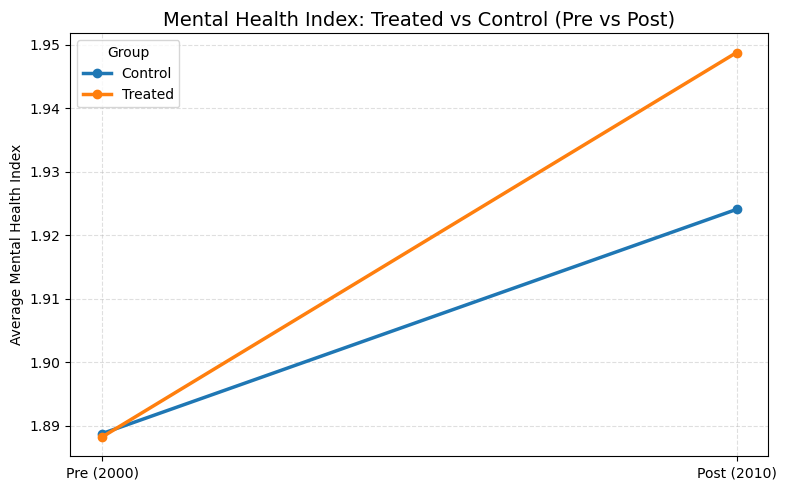

In [115]:
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------------------
# 1. Compute group means (Pre vs Post)
# -----------------------------------------
mean_table = (
    df_reg.groupby(["treat", "post"])["mh_index"]
          .mean()
          .reset_index()
)

# Rename groups for plotting
mean_table["Group"] = mean_table["treat"].map({0: "Control", 1: "Treated"})
mean_table["Period"] = mean_table["post"].map({0: "Pre (2000)", 1: "Post (2010)"})

# -----------------------------------------
# 2. Pivot for easier plotting
# -----------------------------------------
plot_df = mean_table.pivot(index="Group", columns="Period", values="mh_index")

# -----------------------------------------
# 3. Create Plot
# -----------------------------------------
plt.figure(figsize=(8, 5))

# Plot each group
for group in plot_df.index:
    plt.plot(
        ["Pre (2000)", "Post (2010)"],
        plot_df.loc[group],
        marker="o",
        linewidth=2.5,
        label=group
    )

# -----------------------------------------
# 4. Style the graph
# -----------------------------------------
plt.title("Mental Health Index: Treated vs Control (Pre vs Post)", fontsize=14)
plt.ylabel("Average Mental Health Index")
plt.xlabel("")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Group")
plt.tight_layout()

plt.show()
